In [2]:
from core.analysis import *
from core.metrics import *
from core.semcor_bert_pipeline import get_pos

<Figure size 432x288 with 0 Axes>

In this notebook, we compare the correlations between human similarity data with the cosine distance matrices of the full BERT embeddings and the subsets of the embeddings we found were useful in discriminating between a type's senses.

# Comparing Relatedness to Cosine Distance

## Data Prep

In [3]:
db = access_db()

In [5]:
results = pd.read_csv("../data/approved_expt_results.csv")
incl_users = results['userID'].unique()

In [7]:
shared_words = ['foot_n', 'table_n', 'plane_n', 'degree_n', 'right_n', 'model_n']
lemma_counts = get_lemma_counts(results, incl_users, db)
test_repeat_words = lemma_counts[lemma_counts['num_trials'] > 10]['lemma'].tolist()
all_words = shared_words + test_repeat_words

In [8]:
matrices = {}
#Dictionary with type -> {expt: mean distance matrix, bert_full: cosine distance matrix for full embeddings, 
#bert_selected: cosine distance matrix for embeddings selected by L1 Regularization}
for w in all_words:
    matrices[w] = {}
    word, pos = w.split('_')
    cs_mtx_full, _ = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                                                    use_masc = False, normalize = True)
    matrices[w]['bert_full'] = cs_mtx_full
    if w in test_repeat_words:
        expt_mtx = get_test_result_data(results, w, incl_users)
    else:
        expt_mtx = mean_distance_mtx(results, w, 'shared', incl_users, normalize = True)
    matrices[w]['expt'] = expt_mtx
    cs_mtx_sel, _ = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                                                    corpus = 'select_weights', use_masc = False, normalize = True)
    matrices[w]['bert_selected'] = cs_mtx_sel

In [9]:
all_human_avg = [matrices[w]['expt'] for w in all_words]
all_bert_full = [matrices[w]['bert_full'] for w in all_words]
all_bert_sel = [matrices[w]['bert_selected'] for w in all_words]

In [10]:
results['num_senses'] = results['lemma'].apply(get_num_senses, args = [db])
results['pos'] = results['lemma'].apply(get_pos, args = ['_'])
all_trials = results[results['lemma'].isin(all_words) & (results['userID'].isin(incl_users))]

## Global Correlations

There's still less of a correlation than the shared words alone, but there's a very low drop if we use the parts of the embeddings w/nonzero weights only

In [11]:
pd.DataFrame(pd.Series({'Embeddings with Nonzero Weights': mtx_correlation(all_human_avg, all_bert_sel, method = 'spearman')[0],
'Full Embeddings': mtx_correlation(all_human_avg, all_bert_full, method = 'spearman')[0]}),
             columns = ['Spearman Correlation with Average Reported Distance'])

,Spearman Correlation with Average Reported Distance
Embeddings with Nonzero Weights,0.521778
Full Embeddings,0.544198


## POS Correlations

There is not much of a difference between the correlations between BERT and human data across nouns and verbs. This is the case for both the full embeddings and the items in the vector important in sense discrimination.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
pos_results

,BERT Embedding Type,Part of Speech,Spearman Correlation with Average Reported Distance
0,Full Embeddings,Nouns,"(0.4874626437133006, 2.1660971122609556e-08)"
1,Full Embeddings,Verbs,"(0.6234187556199298, 6.367783532663593e-09)"
2,Embeddings with Nonzero Weights,Nouns,"(0.45396299132103185, 2.429627621769828e-07)"
3,Embeddings with Nonzero Weights,Verbs,"(0.6076406777397705, 1.9187202588252973e-08)"


<Figure size 720x576 with 0 Axes>

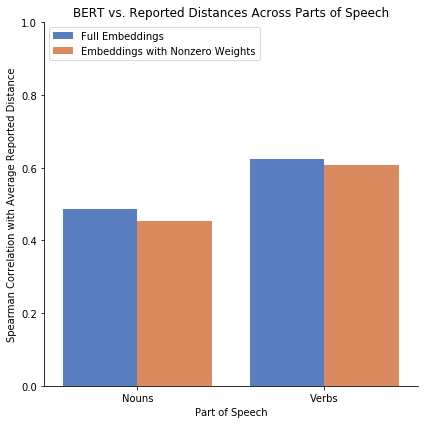

In [16]:
pos_results = []
for e in ['bert_full', 'bert_selected']:
    if e == 'bert_full':
        legend_val = "Full Embeddings"
    else:
        legend_val = "Embeddings with Nonzero Weights"
    for p in ['n', 'v']:
        if p == 'n':
            pos_label = 'Nouns'
        else:
            pos_label = 'Verbs'
        pos_results.append({"BERT Embedding Type": legend_val, "Part of Speech": pos_label, 
                            "Spearman Correlation with Average Reported Distance": 
                            containing_query(all_trials, 'pos', [p], matrices, bert_key = e)[0]})
pos_results = pd.DataFrame(pos_results)
plt.figure(figsize = (10, 8))
sns.catplot(x="Part of Speech", y="Spearman Correlation with Average Reported Distance", hue="BERT Embedding Type",
            data=pos_results, legend = False,
                height=6, kind="bar", palette="muted")
plt.title("BERT vs. Reported Distances Across Parts of Speech")
plt.ylim(0, 1)

plt.tight_layout()
plt.legend(loc = 'upper left')
plt.savefig("../../results/figures/pos_cos_corr.png")

## Correlation with Number of Senses

The correlation between human intuition and BERT data does not decrease monotonically, though this could be an artifact of there being fewer words with more senses.

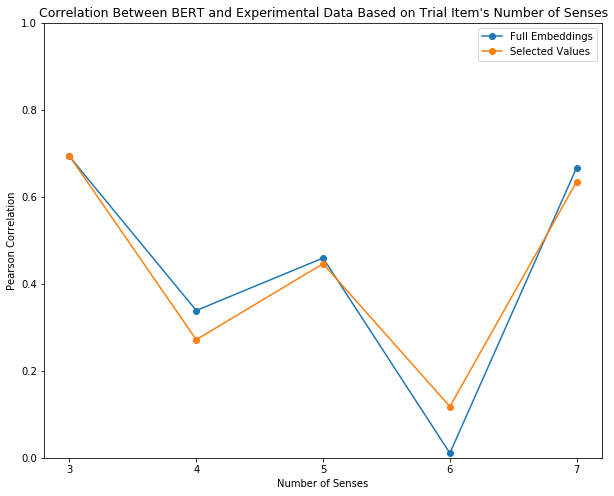

In [23]:
plt.figure(figsize = (10, 8))
plt.plot(range(3, 8),
         [containing_query(all_trials, 'num_senses', [i], matrices, bert_key = 'bert_full') for i in range(3, 8)], 
         marker = 'o', label = 'Full Embeddings')
plt.plot(range(3, 8),
         [containing_query(all_trials, 'num_senses', [i], matrices, bert_key = 'bert_selected') for i in range(3, 8)],
         marker = 'o', label = 'Selected Values')
plt.xlabel("Number of Senses")
plt.ylabel("Pearson Correlation")
plt.xticks(np.arange(3, 8))
plt.title("Correlation Between BERT and Experimental Data Based on Trial Item's Number of Senses", fontsize = 12.5)
plt.legend()
plt.ylim(0, 1)
plt.savefig('../../results/figures/num_senses_corr.png')

## Correlations based on Entropy

BERT embeddings are far less correlated with human relatedness judgements for high entropy types. Correlation decreases by around 0.4).

In [17]:
semcor_entropy = pd.read_csv('../data/expt_semcor_types_revised.csv') #Reading entropy in
semcor_entropy['lemma'] = semcor_entropy['Lemma'].apply(lambda l: l.replace('.', '_'))
semcor_entropy.drop('Lemma', axis = 1, inplace = True)
all_entropy = all_trials.merge(semcor_entropy, on = 'lemma')

In [19]:
entropy_results

,Entropy Level,BERT Embedding Type,Correlation with Average Reported Distance
0,Low/Medium,Full Embeddings,0.570738
1,High,Full Embeddings,0.345577
2,Low/Medium,Embeddings with Nonzero Weights,0.511466
3,High,Embeddings with Nonzero Weights,0.342535


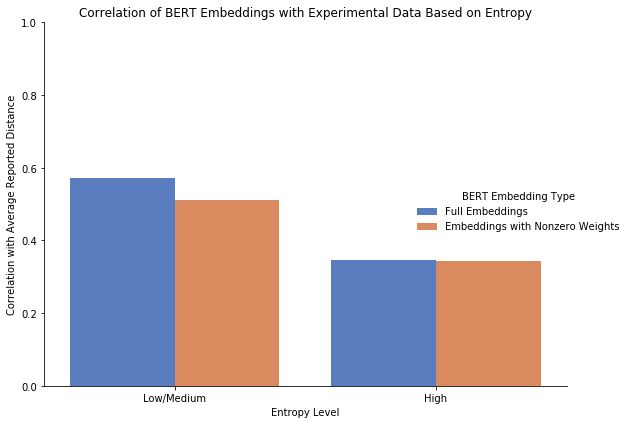

In [18]:
entropy_results = []
for e in ['bert_full', 'bert_selected']:
    if e == 'bert_full':
        legend_val = "Full Embeddings"
    else:
        legend_val = "Embeddings with Nonzero Weights"

    for b in [(0, 1.45), (1.45, 2.5)]:
        corr_for_ent = range_query(all_entropy, 'entropy', b[0], b[1], matrices, bert_key = e)[0]
        if b[0] == 0:
            ent_level = 'Low/Medium'
        else:
            ent_level = 'High'
        entropy_results.append({"Entropy Level": ent_level, 'BERT Embedding Type': legend_val,
                                    "Correlation with Average Reported Distance": corr_for_ent})
entropy_results = pd.DataFrame(entropy_results)
sns.catplot(x="Entropy Level", y="Correlation with Average Reported Distance", hue="BERT Embedding Type", data=entropy_results,
                height=6, kind="bar", palette="muted")
plt.title("Correlation of BERT Embeddings with Experimental Data Based on Entropy")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('../../results/figures/entropy_corr.png')

# Comparing Experimental Data with Confusion Matrices

In [28]:
with open('../data/test_confusion_matrices.json', 'r') as f:
    confusion_mtx = json.load(f)

In [29]:
for w in matrices:
    if w in confusion_mtx:
        matrices[w]['confusion'] = np.array(confusion_mtx[w])

In [132]:
def mtx_correlation(m1, m2, method = 'spearman', randomize_m1_labels = False, confusion = False): 
    #m1 and m2 are lists of distance matrices, spearman or pearson correlation
    #assert len(m1) == len(m2)
    if confusion:
        return stats.spearmanr(m1, m2)[0]
    else:
        flat_m1 = []
        for i in range(len(m1)):
            #OpTimiZAtIoNS
            ut_m1 = m1[i][np.triu_indices(m1[i].shape[0], k = 1)]
            if randomize_m1_labels:
                np.random.shuffle(ut_m1)
            flat_m1 += ut_m1.tolist()
        flat_m2 = []
        for i in range(len(m2)):
            ut_m2 = m2[i][np.triu_indices(m2[i].shape[0], k = 1)]
            flat_m2 += ut_m2.tolist()
        if method == 'spearman':
            return stats.spearmanr(flat_m1, flat_m2)[0]
        if method == 'pearson':
            return stats.pearsonr(flat_m1, flat_m2)[0]


Confusion matrices (shows how probe discriminates between senses) is more correlated with human relatedness judgements than the cosine distances. BERT isn't great at approximating these, but captures some signal.

In [30]:
flatten = lambda l: [item for sublist in l for item in sublist]

test_human_avg = [flatten((1 - matrices[w]['expt']).tolist()) for w in test_repeat_words]
conf = [flatten(matrices[w]['confusion']) for w in test_repeat_words]
print("Spearman Correlation between Human Data and Confusion Matrices",
      stats.spearmanr(flatten(test_human_avg), flatten(conf)))

Spearman Correlation between Human Data and Confusion Matrices SpearmanrResult(correlation=0.628775736740911, pvalue=1.8642698726752398e-50)


In [24]:
def range_query(df, value, low, high, dist_mtx_dict, bert_key = 'bert'):
    #Inclusive of low and high
    words_with_crit = df[(df[value] >= low) & (df[value] <= high)]['lemma'].unique()
    data_for_words = {w : dist_mtx_dict[w] for w in words_with_crit}
    if bert_key == 'confusion':
        expt_data = [(1 - data_for_words[w]['expt']).tolist() for w in data_for_words]
        conf_matrices = [data_for_words[w][bert_key] for w in data_for_words]

        return stats.spearmanr(flatten(flatten(expt_data)), flatten(flatten(conf_matrices)))[0]

    return mtx_correlation([data_for_words[w]['expt'] for w in data_for_words],
                          [data_for_words[w][bert_key] for w in data_for_words])[0]


Again, we see barely any differences across PoS when looking at confusion matrices vs. relatedness.

In [31]:
test_rep_matrices = {k:v for k,v in matrices.items() if k in test_repeat_words}
test_rep_trials = all_trials[all_trials['trialType'].isin(['test', 'repeat'])]
for p in ['n', 'v']:
    print(p, "Correlation with Average Reported Distance",
          containing_query(test_rep_trials, 'pos', [p], test_rep_matrices, bert_key = 'confusion'))


n Correlation with Average Reported Distance (-0.23494088248880945, 0.018627344781285488)
v Correlation with Average Reported Distance (-0.28915907641989896, 0.014455422941964953)


Discrimination is robust across the number of senses

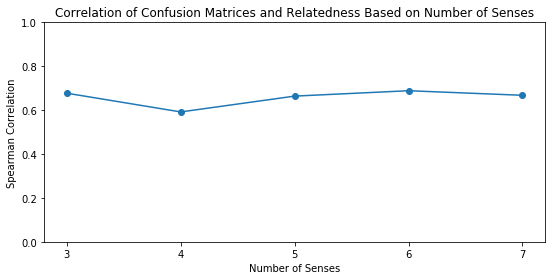

In [81]:
plt.figure(figsize = (8, 4))
plt.plot(range(3, 8),
         [containing_query(test_rep_trials, 'num_senses', [i],
                           test_rep_matrices, bert_key = 'confusion') for i in range(3, 8)], marker = 'o')
plt.xlabel("Number of Senses")
plt.ylabel("Spearman Correlation")
plt.title("Correlation of Confusion Matrices and Relatedness Based on Number of Senses")
plt.ylim(0, 1)
plt.xticks(np.arange(3, 8))
plt.tight_layout()
plt.savefig('../../results/figures/conf_num_senses.png')

Again, we see that the correlation between confusion matrices and human relatedness judgements decreases substantially (by around 0.3) for low entropy types.

In [32]:
test_rep_entropy = all_entropy[all_entropy['trialType'].isin(['test', 'repeat'])]

print("Correlation for med/low entropy words", range_query(test_rep_entropy, 'entropy', 0, 1.45,
                                                       test_rep_matrices, bert_key = 'confusion'))

Correlation for med/low entropy words 0.7381649761411729


In [33]:
print("Correlation for high entropy words", range_query(test_rep_entropy, 'entropy', 1.45, 2,
                                                       test_rep_matrices, bert_key = 'confusion'))

Correlation for high entropy words 0.5604283861382621
